In [1]:
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
%matplotlib notebook

Going to write a function that will take in the locations of five balls located on the corners of the strike zone (in pixel coordinates), as well as the locations of the top and bottom of the zone (again in pixel coordinates) to establish the bounds of the strike zone. We will then calculate whether the pitch crossed into the zone or not.

In [2]:
def pixel_to_world_coordinate(camera_matrix,point_list):
    # Takes in the camera matrix (numpy array)
    # point_list: list of tuples that contain the u, and v, dimensions of the bounding box and true diameter of the object
    #returns a list of tuples, where each element of the list is a tuple containing the x,y,z coordinates of the center of the object. From the POV of the camera, x refers to movement left and right
    # y refers to movement up and down, and z is depth (closer and farther from the camera). 

    world_coordinate_list = []

    for ball in point_list:
        bounding_box = np.array([ball[0],ball[1]]) #create an array containing the lengths of the bounding box
        Z = ( camera_matrix[0,0]*ball[2] )/np.average(bounding_box) #Calculate Z coordinate. Since these are balls, the boxes should be square. If they're not, we take 
                                                                    # the average of the length of each side to be the size of the ball
        Y = ( ball[1]-camera_matrix[1,2] )/camera_matrix[1,1] #calculate Y coordinate
        X = ( ball[0] - camera_matrix[0,2] )/camera_matrix[0,0] #calculate x coordinate
        world_coordinate_list.append( (X,Y,Z) )
    return world_coordinate_list #list of tuples

Now we are going to make a function that will take in the lengths of the bounding boxes of the balls on the corners of the plate and convert those to world coordinates to get the bounds on the strike zone. 

In [3]:
def build_zone(world_coordinate_list):
    #The world coordinate list should be ordered as follows: The 1st entry should be the position of the ball that is at the back (the point) of the plate, from there, 
    #rotate counterclockwise until every ball on the plate is accounted for. The sixth entry will be the lower bound for the zone, the seventh entry will be the upper bound of the zone
    #We're also going to average over the coordinates of the corners of the zone to mitigate errors in strike zone dimensions
# For the strike zone, the width of the plate from this perspective is the x coordinate (increasing from left to right), the length is the z coordinate (increasing from top to bottom of the screen
#and the y coordinate is the height of the zone coming out of the screen. REMEMBER THIS
     #/\
    #|  |
    #____
    #Front of the zone
    #Front plane of the zone length in x coordinate
    front_plane_length_x = world_coordinate_list[2][0] - world_coordinate_list[3][0] 
    back_plane_length_x = world_coordinate_list[1][0] - world_coordinate_list[4][0] 

    x_length_front = ( front_plane_length_x + back_plane_length_x )/2 #average of the 2 lengths

    #z length of the front zone. This is the depth of the plate

    right_plane_length_z = world_coordinate_list[1][2] - world_coordinate_list[2][2] 
    left_plane_length_z = world_coordinate_list[4][2] - world_coordinate_list[3][2] 

    z_length_front = ( right_plane_length_z + left_plane_length_z )/2 #average of the 2 lengths

    y_bottom =  world_coordinate_list[5][1] #Height of the bottom of the zone
    y_top = world_coordinate_list[6][1] #height of the top of the zone
    y_length = y_top - y_bottom
    #Now for the back of the zone where we have curvature. We want to return the slope of the rear of the zone so we can use that for ball and strike checking later
    back_zone_left_edge_slope = (world_coordinate_list[0][2] - world_coordinate_list[4][2] )/( world_coordinate_list[0][0] - world_coordinate_list[4][0] ) #change in z over change in x babay

    back_zone_right_edge_slope = (world_coordinate_list[0][2] - world_coordinate_list[1][2] )/( world_coordinate_list[0][0] - world_coordinate_list[1][0] ) #change in z over change in x babay
    #Also want x intercepts of both of these lines

    intercept_left = world_coordinate_list[0][2] - back_zone_left_edge_slope*world_coordinate_list[0][0] #calculate z intercept of the left slope of the zone
    intercept_right = world_coordinate_list[0][2] - back_zone_right_edge_slope*world_coordinate_list[0][0] #calculate the z intercept of the right slope
    #We also want the y dimension length of the back of the zone. So the tip of the plate to the back plane of the zone
    z_length_back = ( (world_coordinate_list[0][2] - world_coordinate_list[4][2] ) + (world_coordinate_list[0][2] - world_coordinate_list[1][2] ) )/2 #average over 2 possible lengths for the 
                                                                                                                                                    #length of the triangular part of the zone
    #Going to return these lengths as a dictionary

    zone_dim_dict = {
        'x_length_front': x_length_front,
        'y_bottom': y_bottom,
        'y_top': y_top,
        'y_length': y_length,
        'z_length_front': z_length_front,
        'z_length_back': z_length_back,
        'back_zone_left_slope': back_zone_left_edge_slope,
        'back_zone_right_slope': back_zone_right_edge_slope, 
        'intercept_left': intercept_left,
        'intercept_right': intercept_right
    }

    return zone_dim_dict # return a dictionary of the bounding edges of the zone


In [4]:
def check_strike(ball_position, zone_bounds):
    #ball position: tuple of the world coordinates of the ball
    #Zone bounds: list of tuples that contains the center positions of each of the balls used to mark the edges of the strike zone.
    #The 1st entry should be the position of the ball that is at the back (the point) of the plate, from there, 
    #rotate counter clockwise until every ball on the plate is accounted for. The sixth entry will be the lower bound for the zone, the seventh entry will be the upper bound of the zone
    #We're also going to average over the coordinates of the corners of the zone to mitigate errors in strike zone dimensions
    
    zone_dims_dict = build_zone(zone_bounds)
    
    z_check_front = ball_position[2] >= zone_bounds[3][2] and ball_position[2] <= zone_bounds[3][2] + zone_dims_dict.get('z_length_front') #Check if ball is outside the front of zone to start 
    if z_check_front == True: #Ball is in the front rectangular region of the zone
        x_check_front = ball_position[0] >= zone_bounds[3][0] and ball_position[0] <= zone_bounds[3][0] + zone_dims_dict.get('x_length_front') #Check if ball is in x range of the front of the zone (width of the zone)
        y_check_front = ball_position[1] >= zone_dims_dict.get('y_bottom') and ball_position[1] <= zone_dims_dict.get('y_top') #check if ball is in the height of zone 
        if x_check_front == True and y_check_front == True:
            strike = 1
            return strike

    z_check_back = ball_position[2] >= zone_bounds[4][2] and ball_position[2] <= zone_bounds[4][2] + zone_dims_dict.get('z_length_back') #check if ball z coordinate is in the back portion of the zone (triangular part)
    # print(z_check_back)
    if z_check_back == True:
        #Using the x intercepts of the lines calculated in zone_dims 
        x_check_back = ball_position[0] >= ( ball_position[2] - zone_dims_dict.get('intercept_left') ) / (zone_dims_dict.get('back_zone_left_slope')) \
                        and ball_position[0] <= ( ball_position[2] - zone_dims_dict.get('intercept_right') ) / (zone_dims_dict.get('back_zone_right_slope'))
        
        y_check_back = ball_position[1] >= zone_dims_dict.get('y_bottom') and ball_position[1] <= zone_dims_dict.get('y_top')#check if ball is in the y range of the zone (the height)
        # print(y_check_back)
        if x_check_back == True and y_check_back == True:
            strike = 1
            return strike
    strike = 0
    return strike

In [5]:

def strike_result(point_list, ball_positions):
    result = np.zeros(len(ball_positions))
    count = 0
    for ball_position in ball_positions:
        if check_strike(ball_position, point_list):
            print("ball_position: " + str(ball_position) + " Strike")
            result[count] = 1
        else:
            print("ball_position: " + str(ball_position) + " Ball")
        count = count + 1
    return result
point_list = [(0, 0, -3), 
              (2, 0, -5), 
              (2, 0, -7),  
              (-2, 0, -7),  
              (-2, 0, -5),
              (-6, 0, -5), 
              (-6, 2, -5)]

ball_positions = [(0, 0, -3), 
                (2, 0, -5), 
                (2, 0, -7),  
                (-2, 0, -7),  
                (-2, 0, -5),
                (-6, 0, -5), 
                (-6, 2, -5),  #the five points on the homeplate
                  (1, 1, -4),
                  (2, 1, -6),
                  (0, 1, -7),
                  (-2, 1, -6),
                  (-1, 1, -4),  #the five side of the homeplate
                  (0, 1, -6),
                  (0, 1, -5),
                  (0, 1, -4),  #in the middle 
                  (0, 2, -5),
                  (0, 3, -5)   #check z
                  ]

result = strike_result(point_list, ball_positions)
print()

ball_position: (0, 0, -3) Strike
ball_position: (2, 0, -5) Strike
ball_position: (2, 0, -7) Strike
ball_position: (-2, 0, -7) Strike
ball_position: (-2, 0, -5) Strike
ball_position: (-6, 0, -5) Ball
ball_position: (-6, 2, -5) Ball
ball_position: (1, 1, -4) Strike
ball_position: (2, 1, -6) Strike
ball_position: (0, 1, -7) Strike
ball_position: (-2, 1, -6) Strike
ball_position: (-1, 1, -4) Strike
ball_position: (0, 1, -6) Strike
ball_position: (0, 1, -5) Strike
ball_position: (0, 1, -4) Strike
ball_position: (0, 2, -5) Strike
ball_position: (0, 3, -5) Ball



In [6]:
print(result)

[1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]


In [7]:
zone_dims_dict = build_zone(point_list)

vertices_base = []
for i in range(len(point_list)):
    vertices_base.append( point_list[i][2] + zone_dims_dict.get('y_bottom')  )




In [12]:
def draw_pentagonal_prism(ax, zone_bounds,zone_dims_dict,center=(0, 0, 0)):
    # Define the vertices of a regular pentagon
    size = 1
    # vertices_base = np.array([
    #      [size * np.cos(2 * np.pi * i / 5), size * np.sin(2 * np.pi * i / 5), 0] for i in range(5)
    #  ])
    vertices_base = np.array([
     [zone_bounds[i][0], zone_bounds[i][2] + zone_dims_dict.get('y_bottom'), zone_bounds[i][1] ] for i in range(len(zone_bounds)-2) 
    ])
    height = zone_dims_dict.get('y_length') #top and bottom of the zone
    # Extrude the pentagon to create the sides

    vertices_top = vertices_base + np.array([0, 0, height])
    print((f"top vertices: {vertices_top}"))
    vertices = np.vstack([vertices_base, vertices_top])

    # Create the faces of the prism
    faces = [
        [vertices_base[i], vertices_base[(i + 1) % 5], vertices_top[(i + 1) % 5], vertices_top[i]] for i in range(5)
    ]
    faces.append(vertices_base)
    faces.append(vertices_top)

    # Plot the prism
    ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolor = 'r', alpha = .6))

top vertices: [[ 0 -3  2]
 [ 2 -5  2]
 [ 2 -7  2]
 [-2 -7  2]
 [-2 -5  2]]


<IPython.core.display.Javascript object>


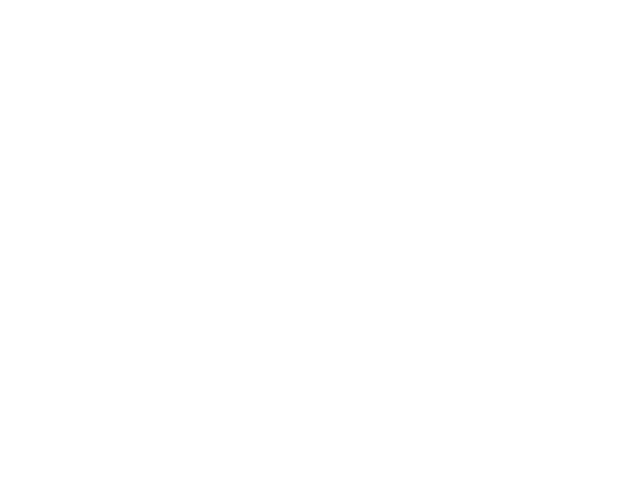

<IPython.core.display.Javascript object>


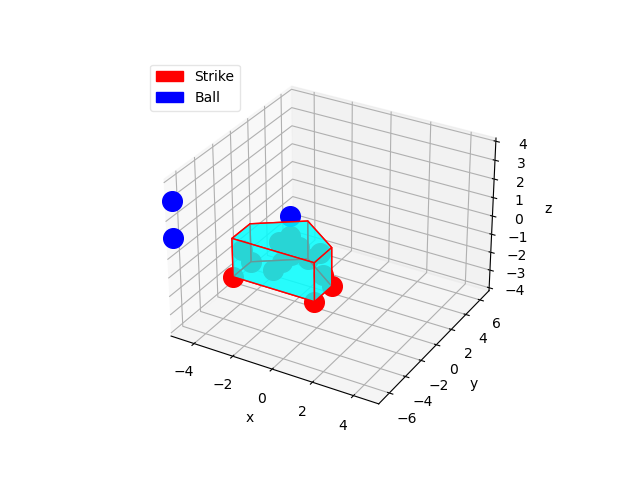

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
height = zone_dims_dict.get('y_length')
center = (point_list[0][0] ,point_list[0][2] + zone_dims_dict.get('z_length_back'),point_list[0][1] + zone_dims_dict.get('y_length')*.5  )

draw_pentagonal_prism(ax = ax,zone_bounds=point_list,zone_dims_dict=zone_dims_dict,center=center)
x_lim = zone_dims_dict.get('x_length_front') + center[0]
y_lim = (zone_dims_dict.get('z_length_front'))+ (zone_dims_dict.get('z_length_back'))
# Set axis limits
ax.set_xlim([-5, 5])
ax.set_ylim([-7, 7])
ax.set_zlim([-2*height, 2*height])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# Create a legend with a color box
strike_patch = mpatches.Patch(color='red', label='Strike')
ball_patch = mpatches.Patch(color='blue', label='Ball')
plt.legend(handles=[strike_patch, ball_patch], loc='upper left', framealpha=0.5, frameon=True)

for i in range(len(ball_positions)):
    if result[i] == 1:
        ax.scatter(ball_positions[i][0],ball_positions[i][2],ball_positions[i][1],c = 'r',s=200)
    else:
        ax.scatter(ball_positions[i][0],ball_positions[i][2],ball_positions[i][1],c = 'b',s=200)

# Enable interactive mode
plt.ion()

# Show the plot
plt.show()

# Pause to allow user interaction
plt.pause(0.1)

# Disable interactive mode
plt.ioff()

# Display the plot
plt.show()

plt.rcParams['savefig.facecolor']='white'
plt.savefig('3d_strikezone_image',bbox_inches="tight")

In [10]:
print(point_list)
print(zone_dims_dict.get('y_bottom'))

[(0, 0, -3), (2, 0, -5), (2, 0, -7), (-2, 0, -7), (-2, 0, -5), (-6, 0, -5), (-6, 2, -5)]
0


In [11]:
vertices_base = np.array([
    [point_list[i][0], point_list[i][1], point_list[i][2] + zone_dims_dict.get('y_bottom')] for i in range(len(point_list)-2) 
])
print(vertices_base)

[[ 0  0 -3]
 [ 2  0 -5]
 [ 2  0 -7]
 [-2  0 -7]
 [-2  0 -5]]
